In [1]:
import pandas as pd
df=pd.read_csv("water_potability.csv")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


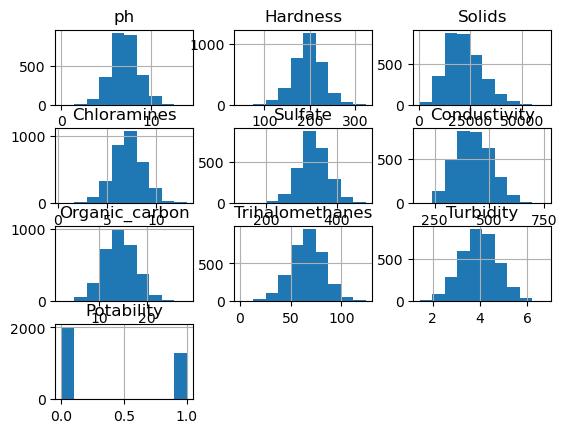

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist()
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
X=df.drop('Potability',axis=1)
y=df['Potability']

correlation_matrix = df.corr()
print(correlation_matrix["Potability"].sort_values(ascending=False))

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64


In [5]:
#Featuer Engeneering

In [6]:
def add_features(X):
    X_df=pd.DataFrame(X)
    X_df['corrosivity']=X_df['Sulfate']/(X_df['Chloramines'] + 1e-5)
    X_df['Mineral_Density']=X_df['Solids']/(X_df['Conductivity'] + 1e-5)
    X_df['Disinfection_Risk']=X_df['Organic_carbon']*X_df['Chloramines']
    return X_df

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier()
pipeline=Pipeline(
    steps=[
        ('ratios', FunctionTransformer(add_features)),
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler()),
        ('model',model)
    ]
)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [9]:
pipeline.fit(X_train,y_train)

,steps,"[('ratios', ...), ('imputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function add...t 0x168a4c400>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [10]:
from sklearn.model_selection import cross_val_score

# We use X and y (the full dataset) here because CV handles the splitting
scores = cross_val_score(pipeline, X, y, cv=5)

print(f"Average Cross-Validation Accuracy: {scores.mean():.2%}")
print(f"Standard Deviation: {scores.std():.4f}")

Average Cross-Validation Accuracy: 63.46%
Standard Deviation: 0.0182


In [11]:
model1=RandomForestClassifier()
pipeline1=Pipeline(
    steps=[
        ('ratios', FunctionTransformer(add_features)),
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler()),
        ('model',model1)
    ]
)

In [12]:
from sklearn.model_selection import cross_val_score

# We use X and y (the full dataset) here because CV handles the splitting
scores = cross_val_score(pipeline1, X, y, cv=5)

print(f"Average Cross-Validation Accuracy: {scores.mean():.2%}")
print(f"Standard Deviation: {scores.std():.4f}")

Average Cross-Validation Accuracy: 63.40%
Standard Deviation: 0.0301


In [13]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameters you want to test
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

# 2. Create the Grid Search object
# cv=5 means it will test every combination 5 times (Cross-Validation)
grid_search = GridSearchCV(pipeline1, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# 3. Run the search
grid_search.fit(X_train, y_train)

# 4. Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.2%}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best Score: 67.86%


In [22]:
model2=RandomForestClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    n_estimators=300,
    random_state=42)
pipeline2=Pipeline(
    steps=[
        ('ratios', FunctionTransformer(add_features)),
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler()),
        ('model',model2)
    ]
)

In [23]:
pipeline2.fit(X_train,y_train)

,steps,"[('ratios', ...), ('imputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function add...t 0x168a4c400>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [24]:
from sklearn.model_selection import cross_val_score

# We use X and y (the full dataset) here because CV handles the splitting
scores = cross_val_score(pipeline2, X, y, cv=5)

print(f"Average Cross-Validation Accuracy: {scores.mean():.2%}")
print(f"Standard Deviation: {scores.std():.4f}")

Average Cross-Validation Accuracy: 63.55%
Standard Deviation: 0.0252


In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pipeline3=Pipeline(
    steps=[
        ('ratios', FunctionTransformer(add_features)),
        ('imputer', IterativeImputer(max_iter=10, random_state=42)),
        ('scaler',StandardScaler()),
        ('model',model2)
    ]
)
pipeline3.fit(X_train,y_train)

In [21]:
from sklearn.model_selection import cross_val_score

# We use X and y (the full dataset) here because CV handles the splitting
scores = cross_val_score(pipeline3, X, y, cv=5)

print(f"Average Cross-Validation Accuracy: {scores.mean():.2%}")
print(f"Standard Deviation: {scores.std():.4f}")

Average Cross-Validation Accuracy: 63.74%
Standard Deviation: 0.0261


In [27]:
import joblib
joblib.dump(pipeline3,'PotabilityPredictor.pkl')
print("Pipeline Saved")

Pipeline Saved
